# Exploring TC PRIMED, Chapter 4: Regridding Satellite Swath Data
- Creators: Kathy Haynes, Naufal Razin, and Chris Slocum
- Affiliations:  CIRA and NESDIS/STAR

___

## Overview
The Tropical Cyclone Precipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED) contains satellite passive microwave data in the original swath format. To apply machine learning approaches to swath data, we must either apply it on a pixel-by-pixel basis or pre-process the swath data. If you've been following along with the notebooks in this series, you would have learned to read, visualize, and analyze TC PRIMED data, as well as how to utilize it for a pixel-based machine learning application. In this notebook, we explore one way to pre-process TC PRIMED swath data for image-based machine learning applications by regridding swath data onto a uniform grid.

## Prerequisites
To successfully navigate and use this notebook, you should be accustomed with:
- Basics of Python programming (e.g., loading modules, variable assignment, plotting, familiarity with scientific Python packages)
- Basics of satellite data (e.g., familiarity with satellite swath data such as that from [low-Earth-orbiting](https://www.esa.int/Enabling_Support/Space_Transportation/Types_of_orbits) satellites)
- [Map projections](https://gisgeography.com/map-projections/) and grid types (e.g., Mercator, Lambert Equal Area)
- [Interpolation methods](https://gisgeography.com/raster-resampling/) (e.g., Nearest Neighbor, Gaussian Weighting, Bilinear)

## Learning Outcomes
After working through this notebook, you should be able to:
- understanding basic satellite swath data (such as that from polar-orbiting satellites)
- execute a remapping of satellite swath data onto a discrete grid

## Background

There are many types of satellite data in meteorological use.
 Geostationary satellites have onboard sensors that view the same portion of the Earth's surface at all times.  In contrast, microwave sensors are found on polar orbiting satellites.  With polar orbiters, the satellite passes over certain portions of the Earth's surface as it travels around the Earth, poleward on one side and then equatorward on the opposite side, creating 'stripes' or swaths of data. During the satellite's travels, the Earth rotates underneath it, allowing the satellite swaths to cover new areas with each consecutive pass.

TC PRIMED is a dataset centered around satellite passive microwave observations of tropical cyclones, and these data are in the form of swaths. The nature of swath data adds complexity for machine learning applications using TC PRIMED, particularly for predicting storm-scale phenomena like the presence of an eye or the current intensity.  Because satellite swath data only covers a portion of the Earth at one time, putting it on a regular grid allows the data to be in a standard, consistent format for machine learning.  Additionally, it allows for the combination and collocation of swath data with other satellite data, allowing you to use different types of satellite data together.

In this notebook, we will use an existing Python package, `pyresample`, to regrid TC PRIMED swath data onto a uniform grid. This regridding process can serve as a pre-processing step in applying more complex machine learning approaches like convolutional neural networks to TC PRIMED data.

### Hurricane Florence (2018)
In this example, we will use TC PRIMED files from Hurricane Florence (2018). If you have gone through the earlier notebooks in this series, you should be familiar with Hurricane Florence. Hurricane Florence was a long-lived hurricane that tracked across the Atlantic to make landfall along the southeastern coast of North Carolina as a high-end Category 1 hurricane.

<figure>
<img alt="An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station." src="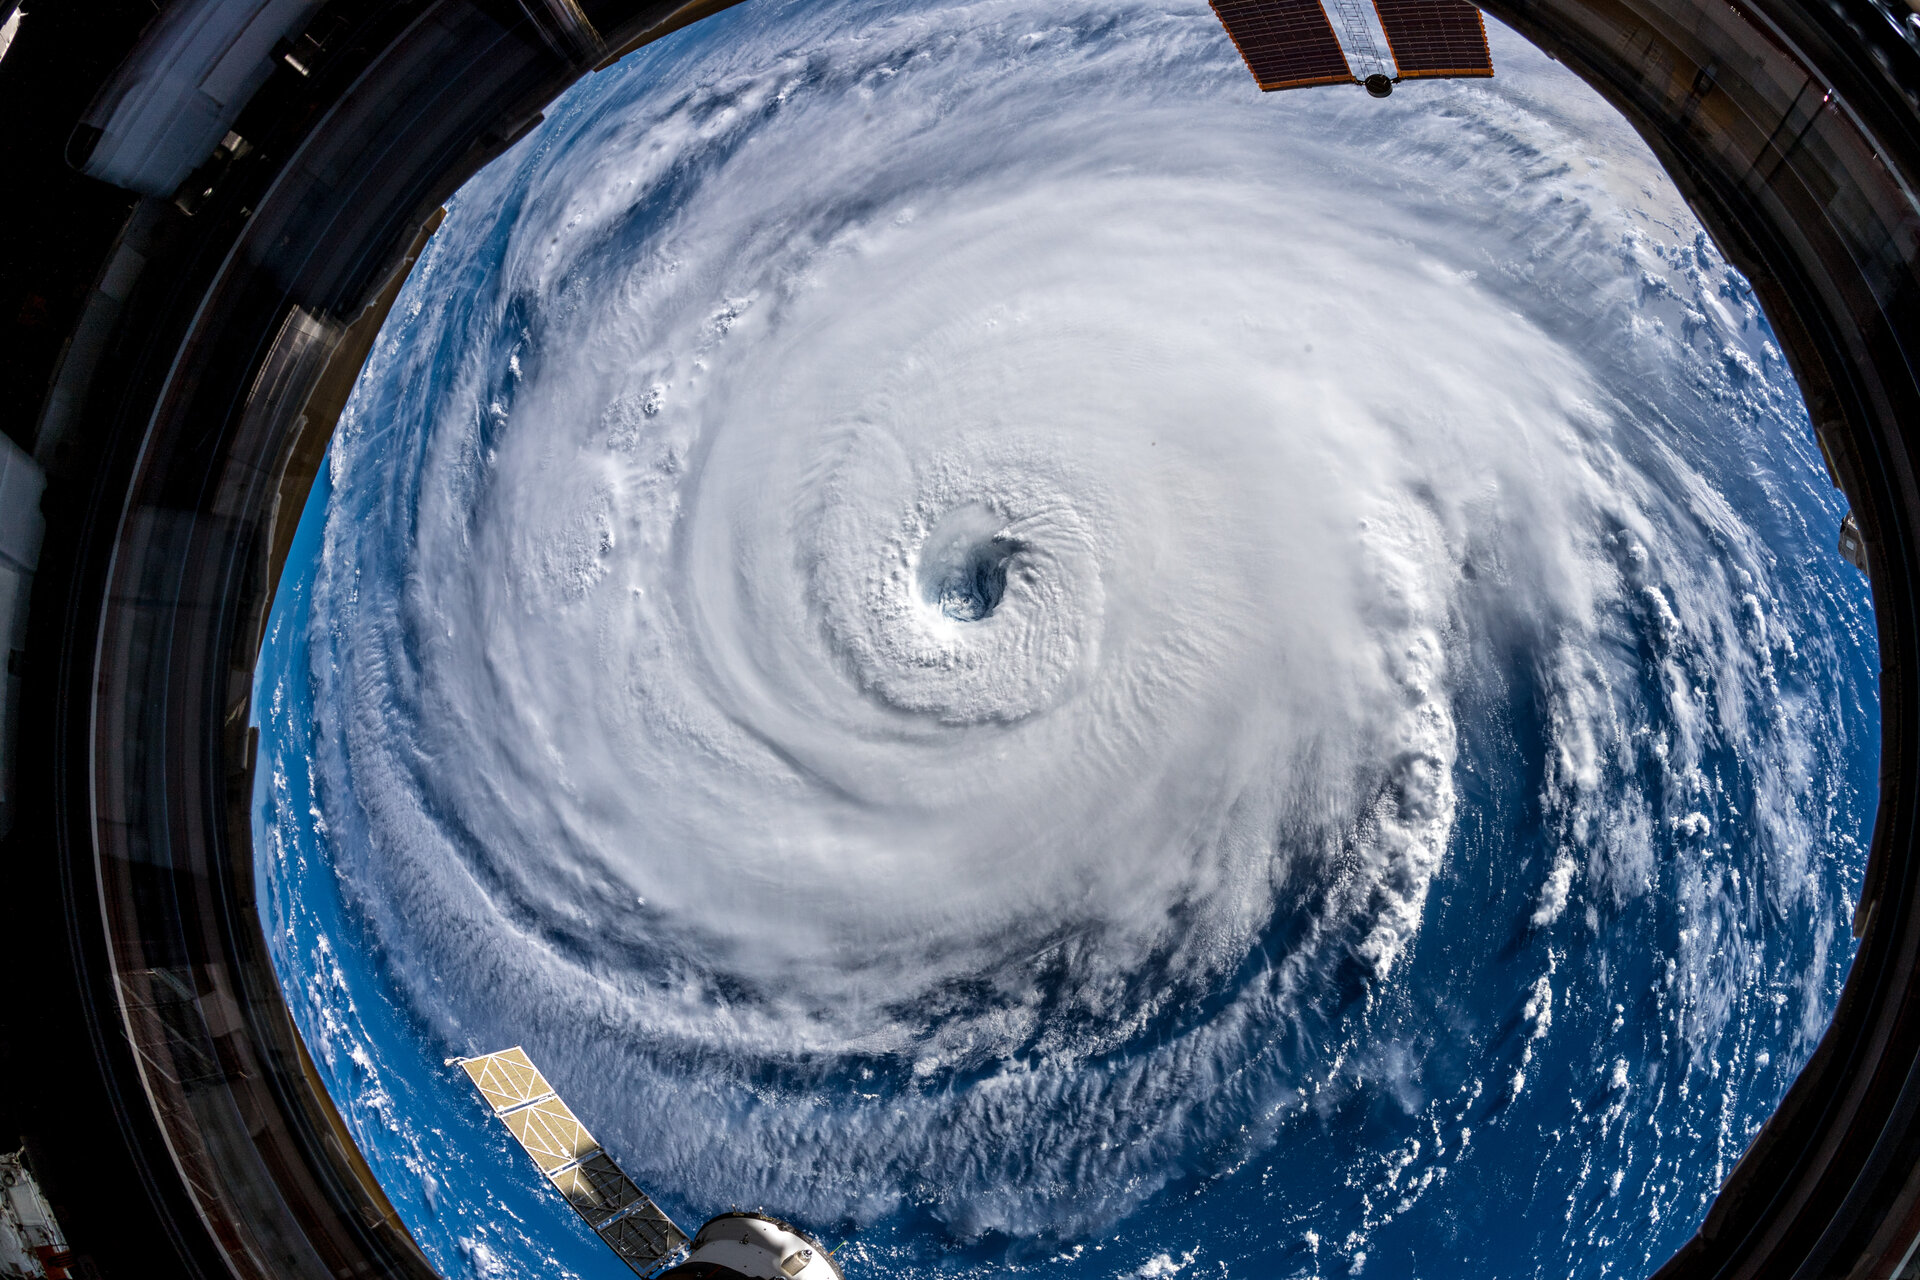" width="900">

<figcaption align = "center"><b>Figure 1.</b> An image of Hurricane Florence (2018) captured by European Space Agency astronaut Alexander Gerst from aboard the International Space Station. Source: <a href="https://www.esa.int/ESA_Multimedia/Images/2018/09/Above_Hurricane_Florence">ESA</a></figcaption>
</figure>

### Passive microwave observations in the 85 to 92 GHz frequency window
In this notebook, we will regrid passive microwave observations in the 85 to 92 GHz frequency window. Observations in this microwave frequency window can penetrate through the cloud tops to reveal the internal storm structure. In essence, it "sees" through cloud tops. In this frequency window, land surfaces appear warm relative to water. In addition, low-level moist air masses act to warm the brightness temperatures over water surfaces, which highlights the warm emission regions of the hurricane where there are rain and cloud water bands. In contrast, deep convection appears relatively cold due to scattering from ice, highlighting the cold scattering regime of the hurricane and areas of deep convection.

## Software
This tutorial uses the Python programming language and scientific Python packages.  We will primarily use:
* `netCDF4` and `numpy` to read in satellite swath data
* `pyresample` to grid the data
* `cartopy` and `matplotlib` for plotting

### Install Packages

Let's first check if we have the necessary Python packages to run this notebook.  If we don't, let's install them.

In [ ]:
import subprocess, sys
packages = ["netCDF4", "numpy", "matplotlib",
            "cartopy", "pyresample"]
# If this notebook is running on Google Colab, we know what packages
# need to be installed. In addition, we would have to resolve some
# incompatibility issues between shapely and cartopy.
if 'google.colab' in sys.modules:
    !pip install netCDF4
    !pip install --upgrade numpy
    !pip install --upgrade matplotlib
    !pip install --no-binary shapely shapely --force
    !pip install cartopy
    !pip install pyresample

# If this note book is not running on Google Colab, check if Python
# has the packages we need to run this notebook. If not, download it.
else:
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

Now, let's load the modules in the packages (e.g., `DownloadWarning`) or load the packages and assign a shorter object name for the packages (e.g., `as ccrs`) for a cleaner use throughout the notebook.

In [ ]:
# Install and import required libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import DownloadWarning

import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from matplotlib.colors import Normalize

from netCDF4 import Dataset
import numpy as np

from pyresample import kd_tree
from pyresample import SwathDefinition
from pyresample.area_config import create_area_def
from pyresample.bilinear import NumpyBilinearResampler
from pyresample.geometry import AreaDefinition
from pyresample.plot import show_quicklook
from pyresample.utils import check_and_wrap

Let's also just suppress any warnings so that we don't have to look through those.

In [ ]:
# Import warnings and suppress relevant categories.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=DownloadWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Read File Online
Finally, let's retrieve information from the TC PRIMED file that we will use in this example. The TC PRIMED file will be from an Advanced Scanning Microwave Radiometer 2 (AMSR2) overpass of Hurricane Florence (2018). We have selected an AMSR2 overpass from Hurricane Florence with good coverage of the storm while it made landfall. We will use the Python `netCDF4` and `requests` packages to read and retrieve the information directly from the TC PRIMED file available on an Amazon Web Service S3 bucket as part of the NOAA Open Data Dissemination program (NODD), without downloading the file, and store the information from the file in an "instance" type called `DS`.

In [ ]:
import requests

# Specify the URL to the TC PRIMED folder on NODD
NODD_URL = "https://noaa-nesdis-tcprimed-pds.s3.amazonaws.com/v01r00/final/2018/AL/06/"

# Specify the name of the file we will use from the TC PRIMED folder on NODD
FILE_NAME = "TCPRIMED_v01r00-final_AL062018_AMSR2_GCOMW1_033650_20180914065914.nc"

# Join NODD_URL and FILE_NAME to produce a complete link
# Retrieve the contents of the TC PRIMED file from the complete link
url_response = requests.get(NODD_URL + FILE_NAME)

# Load the contents of the TC PRIMED file in an "instance" called DS
DS = Dataset(FILE_NAME, memory=url_response.content)

Now that the file is available, let's pull out the necessary information we'll need. Chapter 1b in this notebook series outlined in detail the structure of the TC PRIMED overpass file, so here we will quickly obtain the storm information along with the swath latitude, longitude, and the 89 GHz brightness temperatures.

For the longitude, TC PRIMED uses longitudes from 0 to 360; however, Pyresample needs them to be from -180 to 180.  Here we adjust these to make the longitude in the correct range for regridding.

In [ ]:
# Pull out the storm's center location
storm_latitude = DS["overpass_storm_metadata/storm_latitude"][:][0]
storm_longitude = DS["overpass_storm_metadata/storm_longitude"][:][0]
if storm_longitude > 180:
    storm_longitude -= 360.
print("Storm Center Longitude= {:.2f} E, Latitude= {:.2f} N".\
      format(storm_longitude, storm_latitude))

In [ ]:
# Pull the swath latitude and longitude from the S6 swath
swath_latitude = DS["passive_microwave/S6/latitude"][:]
swath_longitude = DS["passive_microwave/S6/longitude"][:]
swath_longitude[swath_longitude >= 180] -= 360

In [ ]:
# Pull the horizontally-polarized 89 GHz brightness temperature
# from the S6 swath
swath_h89 = DS["passive_microwave/S6/TB_B89.0H"][:]
print("89-GHz Brightness Temperature Minimum= {:.2f}, Maximum= {:.2f}".\
      format(swath_h89.min(), swath_h89.max()))

## Close the File
When loading data from a NetCDF file, **always remember to close the file**. Since we will no longer be retrieving data from the file, we can close the file now.

In [ ]:
# Close the file
DS.close()

## Visualize Swath Data

In order to visualize the passive microwave data throughout this notebook, let's define a function to map the data onto various user-specified projections using `cartopy`.

In [ ]:
# Define function to map 2D data
def map2D(data2D, lon2D, lat2D,
          contours=None,
          cbar=True,
          cmap='viridis',
          cFontSize=16,
          cLabel='K',
          cPad=0.0,
          cTicks=None,
          dLat=0.,
          dLon=0.,
          extent=None,
          figSize=(10, 6),
          fontSize=24,
          gridLines=True,
          gridLineLabels=True,
          labelFormat=None,
          nContours=42,
          projection='Mercator',
          saveFile='',
          title='',
          vmax=None,
          vmin=None
          ):
    """
    Create a map of 2D data with specified latitude and longitude locations.
    Produces an inline figure or a saved file (if saveFile is a file name).

    Parameters
    ----------
    data2D : array-like
        array of 2D data to visualize
    lon2D : array-like
        array of 2D longitudes for the data
    lat2D : array-like
        array of 2D latitudes for the data
    contours : array-like, optional
        array of contour levels for plot, calculated from data
        and nContours if None
    cbar : bool, default=True
        flag to show colorbar
    cmap : str, default='viridis'
        color table of data
    cFontSize : int, default=16
        font size of colorbar
    cLabel : str, default='K'
        colorbar label
    cPad : float, default=0.0
        padding for colorbar
    cTicks : array-like, optional
        specific tick locations for colorbar
    dLat : float, default=0.
        extra latitudes to show outside of data area (degrees)
    dLon : float, default=0.
        extra longitudes to show outside of data area (degrees)
    extent : array-like, optional
         extent of area to show, calculated from data and dLat/dLon if None
    figSize : tuple, default=(10, 6)
        figure size
    fontSize : int, default=24
        font size of figure title
    gridLines : bool, default=True
        flag to show grid lines
    gridLineLabels : bool, default=True
        flag to show grid line labels
    labelFormat : f-str, default=None
        format for colorbar tick labels
    nContours : int, default=42
        number of colorbar contours
    projection : str, default='Mercator'
        projection of background map
    saveFile : str, default=''
        name of file to save image, image saved only if not ''
    title : str, default=''
        figure title, printed only if not ''
    vmax : float, optional
        minimum value for colorbar, calculated from data if None
    vmin : float, optional
        maximum value for colorbar, calculated from data if None

    Yields
    ------
    image of regridded satellite swath data on a map with a projection
    """


    # Get valid data ranges
    myMin = np.nanmin(data2D)
    myMax = np.nanmax(data2D)
    if contours is None:
        cDelta = (myMax - myMin) / (nContours - 2)
        contours = np.empty(nContours)
        for i in range(nContours):
            contours[i] = myMin + i * cDelta - 0.5 * cDelta

    # Setup map projection using cartopy
    cLat = lat2D.min() + (lat2D.max() - lat2D.min()) * 0.5
    cLon = lon2D.min() + (lon2D.max() - lon2D.min()) * 0.5

    if projection == 'LambertConformal':
        crs = ccrs.LambertConformal(
            central_longitude=cLon,
            central_latitude=cLat)
    elif projection == 'PlateCarree':
        crs = ccrs.PlateCarree(central_longitude=cLon)
    elif projection == 'Mollweide':
        crs = ccrs.Mollweide(central_longitude=cLon)
    elif projection == 'Robinson':
        crs = ccrs.Robinson(central_longitude=cLon)
    elif projection == 'Sinusoidal':
        crs = ccrs.Sinusoidal(central_longitude=cLon)
    elif projection == 'LambertConformal':
        crs = ccrs.LambertConformal()
    elif projection == 'AlbersEqualArea':
        crs = ccrs.AlbersEqualArea(
            central_longitude=cLon,
            central_latitude=cLat)
    elif projection == 'LambertAzimuthalEqualArea':
        crs = ccrs.LambertAzimuthalEqualArea(
            central_longitude=cLon,
            central_latitude=cLat)
    elif projection == 'Mercator':
        crs = ccrs.Mercator(central_longitude=cLon)
    else:
        print("Unknown projection, using PlateCarree.")
        crs = ccrs.PlateCarree(central_longitude=cLon)

    # Create the figure and plot the background
    fig, ax = plt.subplots(ncols=1, nrows=1,
                           figsize=figSize,
                           subplot_kw={'projection': crs})

    if extent is None:
        extent = [lon2D.min() - dLon, lon2D.max() + dLon,
                  lat2D.min() - dLat, lat2D.max() + dLat]
    ax.set_extent(extent)
    if gridLines:
        gl = ax.gridlines(draw_labels=gridLineLabels)
        gl.bottom_labels = True
        gl.left_labels = True
        gl.top_labels = False
        gl.right_labels = False

    # Draw the maps
    if labelFormat is None:
        labelFormat = '%.0f'
    cf = ax.contourf(
        lon2D, lat2D, data2D, contours,
        cmap=cmap, vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree())

    ax.add_feature(
        cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=fontSize)

    if cbar:
        cb = fig.colorbar(cf, ax=ax, format=labelFormat, pad=cPad)
        cb.ax.tick_params(labelsize=cFontSize)
        cb.set_label(cLabel, size=cFontSize)

    if cTicks is not None:
        tick_locator = ticker.MaxNLocator(nbins=cTicks)
        cb.locator = tick_locator
        cb.update_ticks()

    if saveFile == '':
        plt.show()
    else:
        plt.savefig(saveFile, bbox_inches="tight")

To make sure we have consistent colorscales between all our figures, we'll specify the colormap along with the `vmin` and `vmax` values of the colorabar based on the minimum and maximum values of the original swath data. We also need to set the extent of the area we want to show in the image, which we can do by specifying `DLAT` and `DLON` to specify the distance, in degrees, to show from the image center.

In [ ]:
# Plot the satellite swath
CMAP = 'viridis'
VMIN = swath_h89.min()
VMAX = swath_h89.max()
DLAT = 5   # Extent of lat from center (degrees)
DLON = 10  # Extent of lon from center (degrees)

The mapping function we have defined also allows us to specify the projection of the map, which does not have to be the same projection as the data, thanks to `cartopy`.  Here we have chosen to show the data on the Robinson projection, to somewhat reduce the projection stretching in higher latitudes than would be for the Mercator projection.

In [ ]:
PROJECTION = 'Robinson'

With these set, we can make our figure showing the original passive microwave swath data.

In [ ]:
map2D(swath_h89, swath_longitude, swath_latitude,
      cmap=CMAP,
      dLat=DLAT, dLon=DLON,
      projection=PROJECTION,
      vmin=VMIN, vmax=VMAX)

Looking at this image, the horizontal polarization near 89 GHz shows ice scattering in deep convection surrounding the storm center as it travels on land.  It also shows cirrus as well as warm rain against the low emissivity ocean background scene.

## Regridding Swath Data
When regridding swath data onto a uniform grid, you have to specify a projection. Multiple projections are available. Here, we explore regridding our swath data using the Mercator projection.

### Defining the swath
In order for `pyresample` to properly interpret the satellite swath data, we have to define the area of the swath data. We can easily define this area using the swath latitude and longitude values from the TC PRIMED file.

Recall that for `pyresample` we need to have the longitudes from -180 to 180, rather than 0 to 360 like that available in TC PRIMED files. While we have changed the longitude values when we loaded the data above, let's go ahead and check to make sure that our latitudes and longitudes are in the correct format for `pyresample` to interpret.

In [ ]:
# Latitude and longitude format check
swath_longitude, swath_latitude = check_and_wrap(swath_longitude, swath_latitude)

Now that we are sure that our longitude and latitude values are correctly formatted, we can define our satellite swath.

In [ ]:
# Swath definition
swath = SwathDefinition(swath_longitude, swath_latitude)

### Setting up the Mercator projection
In order to regrid the swath data onto a uniform grid, we first need to define the projection for the new grid.  In `pyresample`, we do this by defining a dictionary where:
* the projection is specificed as Mercator,
* the central longitude is the longitude of the storm center
* the radius for the projection is Earth's radius.



In [ ]:
# Create a dictionary specifying the projection
RADIUS_EARTH = 6371228.
proj_dict_merc = {
    'proj': 'merc',
    'lon_0': storm_longitude,
    'R': int(RADIUS_EARTH),
    'units': 'm'}

Next we can setup the specific area-related parameters for our Mercator projection.
* To have the tropical cyclone be perfectly centered in our image, we'll create a new square grid, with matching `x` and `y` dimensions (*nx*, *ny*). Here, we'll create a new grid of 390 by 390 pixels.
* Since we'd like to match other satellite data that may have higher resolutions, we'll use spatial resolutions (*dx*, *dy*) that correspond to 2 km.  Using the great circle approximation, this evaluates to `dx=0.03593244699965226` and `dy=0.03593244699963805`.

In [ ]:
# Define the parameters necessary for the Mercator projection
NX = 390  # number of pixels in x-direction (longitude)
NY = 390  # number of pixels in y-direction (latitude)
DX = 0.03593244699965226  # longitude spatial resolution (degrees)
DY = 0.03593244699963805  # latitude spatial resolution (degrees)

Now that we have those parameters set, we can create our new projection area using `pyresample`'s `create_area_def` function.  To keep the storm centered in our new projection, we will center the new projection on the storm longitude and latitude obtained from the TC PRIMED file.

In [ ]:
# Define the mercator projection
AREA_ID = 'Mercator'
merc_area = create_area_def(
    AREA_ID, proj_dict_merc,
    center=(storm_longitude, storm_latitude),
    shape=(NX, NY),
    resolution=(DX, DY),
    units='degrees')

In order to plot the data on this new projection, we will need the associated latitude and longitude of this new grid area.  Using `pyresample`'s area definition, we can easily pull out the full spatial 2D arrays.

Since the Mercator projection is a uniform grid, we could reduce the arrays to 1D in order to minimize duplicity; however, for this notebook we will keep it in 2D to be consistent with the rest of TC PRIMED data.  Note that if you do reduce down to 1D arrays, 2D data can be regenerated using [numpy's meshgrid function](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html).

In [ ]:
# Pull out the latitude and longitude
merc_longitude, merc_latitude = merc_area.get_lonlats()
print("Mercator Longitude Shape: {}".format(merc_longitude.shape))
print("Mercator Latitude Shape: {}".format(merc_latitude.shape))

### How should you interpolate the data?
To put the swath data onto the new grid, the data has to be interpolated to create new values corresponding to the new spatial locations.  `pyresample` offers several different interpolation methods. Here, we demonstrate two [commonly used methods](https://gisgeography.com/raster-resampling/):
* Nearest Neighbor
* Bilinear Interpolation

Both of these methods have different strengths and weaknesses. While we won't go into these methods in depth, here we're providing examples of both so that you can easily experiment with them to suit your needs.

#### Mercator projection using nearest neighbor
Here, we'll use `pyresample` to regrid the swath data onto a Mercator grid using the nearest neighbor interpolation method.  One important parameter of this method is the radius of influence, which is the radius around each grid pixel in meters to search for neighbours in the swath.  Note that this distance needs to be large enough to ensure finding a neighbor for the target from the original data.

In [ ]:
# Nearest neighbor grid interpolation
RADIUS_NN = 20000.  # radius of influence (m)
mercNN_h89 = kd_tree.resample_nearest(
    swath, swath_h89, merc_area,
    radius_of_influence=RADIUS_NN)
print("Mercator Data Shape: {}".format(mercNN_h89.shape))
print("     Min= {:.2f}, Max= {:.2f}".format(\
    mercNN_h89.min(), mercNN_h89.max()))

Printing the shape, we see as expected the new data has 390 by 390 pixels.

`pyresample` provides a routine to quickly plot the data, which we can use as a way to quickly ensure there are no obvious errors in the new data.

In [ ]:
# Quickly plot the new data
show_quicklook(merc_area, mercNN_h89,
               cmap=CMAP,
               vmin=VMIN, vmax=VMAX)

To visually compare our results with the original swath data, we can use the same plotting function defined above to plot the data, using the latitude and longitude values from the Mercator area we defined.

In [ ]:
# Plot the data on Mercator projection from 2D lat/lon
map2D(mercNN_h89, merc_longitude, merc_latitude,
      cmap=CMAP,
      dLat=DLAT, dLon=DLON,
      projection=PROJECTION,
      vmin=VMIN, vmax=VMAX)

Through visual comparison, the interpolated image look nearly identical to the swath image above!

#### Mercator projection using bilinear interpolation
Bilinear interpolation is another common interpolation method offered by `pyresample`. Key parameters for this method include:
* radius: The radius around each target pixel in meters to search for neighbours in the source data. Again note that this distance needs to be large enough to ensure finding a neighbor for the target from the original data.
* neighbours: The number of closest locations to consider when selecting the four data points around the target location. Note that this number needs to be large enough to ensure surrounding the target.



In [ ]:
# Set bilinear interpolation parameters
RADIUS_BILINEAR = 30000
NEIGHBORS_BILINEAR = 32

Similar to the steps above, we can convert the swath data to a Mercator projection using this interpolation method. This method requires you to first define a resampler object, where you specify the original area (here the swath area), the new area (here the Mercator grid), and the desired parameters.

In [ ]:
bt_resampler = NumpyBilinearResampler(
    swath, merc_area,
    RADIUS_BILINEAR,
    neighbours=NEIGHBORS_BILINEAR)

Once we have defined the resampler object, we can then use it on our swath data to perform the regridding.

In [ ]:
mercB_h89 = bt_resampler.resample(swath_h89)
print("Mercator Data Shape: {}".format(mercB_h89.shape))
print("     Min= {:.2f}, Max= {:.2f}".format(\
    mercB_h89.min(), mercB_h89.max()))

And now we can plot the results:

In [ ]:
# Plot the data on Mercator projection from 2D lat/lon
map2D(mercB_h89, merc_longitude, merc_latitude,
      cmap=CMAP,
      dLat=DLAT, dLon=DLON,
      projection=PROJECTION,
      vmin=VMIN, vmax=VMAX)

Again we see results very similar to the original swath data, as well as from using nearest neighbor interpolation.

### Lambert Azimuthal Equal Area (LAEA) projection
As a final demonstration, we'll show how easily we can use `pyresample` to transform swath data to a different projection. Here we'll try the lambert azimuthal equal area projection, again centered on the tropical cyclone. Recall, the steps to do this are simple:
1. Create swath definition (done!)
2. Create new projection definition
3. Specify the projection area
4. Create new data using selected interpolation method

In defining the LAEA projection, we need to specify both the central latitude and the central longitude.  Again, since we already have the storm location from TC PRIMED we will use these.

In [ ]:
# Define lambert azimuthal equal area projection
laea_projection = {
    'proj': 'laea',
    'lat_0': storm_latitude,
    'lon_0': storm_longitude,
    'a': RADIUS_EARTH,
    'units': 'm'}


In setting up the specific area for our LAEA projection, we will use parameter values to give us a similar area to our Mercator projection area.
* To have the tropical cyclone be perfectly centered, we'll create a new square grid, with matching width and height dimensions with the same number of pixels as previously (*nx*, *ny*).
* Rather than specifying the resolutions, this projection requires us to specify the area extent. Because we want a square with 2 km resolution, we set that up going equal distances from the center in both x- and y- directions.

In [ ]:
LAREA_WIDTH = NX   # width size (pixels)
LAREA_HEIGHT = NY  # height size (pixels)
LAREA_RES = 2000   # grid resolution (m)
laea_extentx = LAREA_RES * LAREA_WIDTH  # one-sided width extent
laea_extenty = LAREA_RES * LAREA_HEIGHT # one-sided height extent
laea_extent_area = (\
      -laea_extentx, -laea_extenty,
      laea_extentx, laea_extenty)


After setting the parameters, we can define the LAEA area using `pyresample`'s `AreaDefinition`.

In [ ]:
LAREA_ID = 'LAEA'
LAREA_DESCRIPTION = 'LAEA Example'
LAREA_PROJECT_ID = 'TC-PRIMED Example'
laea_area = AreaDefinition(
    LAREA_ID,
    LAREA_DESCRIPTION,
    LAREA_PROJECT_ID,
    laea_projection,
    LAREA_WIDTH,
    LAREA_HEIGHT,
    laea_extent_area)

Now we can interpolate the swath data, here using the nearest neighbors approach.

In [ ]:
# Create regridded data using nearest neighbor
laeaNN_h89 = kd_tree.resample_nearest(
    swath, swath_h89, laea_area,
    radius_of_influence=RADIUS_NN,
    fill_value=np.nan)
print("LAEA Data Shape: {}".format(laeaNN_h89.shape))
print("     Min= {:.2f}, Max= {:.2f}".format(\
    np.nanmin(laeaNN_h89), np.nanmax(laeaNN_h89)))

Finally we can plot the results using latitudes and longitudes from the lambert equal area definition.

In [ ]:
# Plot lambert azimuthal equal area data
laea_longitude, laea_latitude = laea_area.get_lonlats()
map2D(laeaNN_h89, laea_longitude, laea_latitude,
      cmap=CMAP,
      dLat=DLAT, dLon=DLON,
      projection=PROJECTION,
      vmin=VMIN, vmax=VMAX)

Here we see that the values are similar, but the corners of the image are cutoff due to the different projection area.

## Comparing passive microwave data with precipitation
Observations in the different passive microwave frequencies provide us with information on the various properties of the atmosphere (e.g., temperature, moisture, presence of liquid or frozen precipitation). These different information allow us to estimate the precipitation structure within the passive microwave swath. Along with passive microwave brightness temperature observations, TC PRIMED also contains passive-microwave-based rainfall retrievals from NASA's Goddard PROFiling algorithm (GPROF). Using the precipitation information from the same file as above, let's load, regrid and plot the GPROF surface precipitation rates from Hurricane Florence, and compare the surface precipitation rates with the passive microwave observation from above.

### Read and visualize precipitation data
First, let's obtain the GPROF surface precipitation rate data from the same TC PRIMED overpass file as above. The surface precipitation rate data is stored in the `S1` swath of the GPROF group in the TC PRIMED overpass file.

In [ ]:
# Read precipitation from the same TC PRIMED overpass file
DS = Dataset(FILE_NAME, memory=url_response.content)
precip_latitude = DS["GPROF/S1/latitude"][:]
precip_longitude = DS["GPROF/S1/longitude"][:]
precip_longitude[precip_longitude > 180] -= 360
precip_data = DS["GPROF/S1/surfacePrecipitation"][:]
precip_units = DS["GPROF/S1/surfacePrecipitation"].units
print("GPROF Precipition Shape: {}".format(precip_data.shape))
print("     Min= {:.2f}, Max= {:.2f} ({})".\
      format(precip_data.min(), precip_data.max(),
      precip_units))
DS.close()

To get an idea of what the precipitation looks like for Hurricane Florence at the overpass time, we can use our mapping routine to plot the precipitation data.

In [ ]:
# Map the original precipitation data
map2D(precip_data, precip_longitude, precip_latitude,
      cLabel='mm/h', cmap=CMAP,
      dLat=DLAT, dLon=DLON,
      projection=PROJECTION)

Looking closely at the map of the original precipitation swath, notice that there are points over western Pennsylvania and southwestern New York where data is missing. We can use the data mask to set any missing value to zero to ensure that the regridding process goes smoothly.

In [ ]:
# Replace any bad values with zero
precip_data = np.where(precip_data.mask, 0.0, precip_data)

### Regrid the precipitation data
Next, in order to directly compare the passive microwave data with the precipitation data, we can put them both on the same uniform grid.  Here we will use the Mercator grid that we have already used for the microwave data.  To regrid the precipitation data, recall we first need to define the swath area of the precipitation data.

In [ ]:
# Define precipitation swath area
precip_swath = SwathDefinition(precip_longitude, precip_latitude)

Using the swath areal definition, now we can interpolate the precipitation swath onto the Mercator grid.

In [ ]:
# Regrid precipitation onto Mercator grid
# using nearest neighbor interpolation
mercNN_precip = kd_tree.resample_nearest(
    precip_swath, precip_data, merc_area,
    fill_value=0.,
    radius_of_influence=RADIUS_NN)
print("Regridded precip Min={:.2f}, Max={:.2f}".\
      format(mercNN_precip.min(), mercNN_precip.max()))

Just for a sanity check, let's quickly check the size of our regridded precipitation data with the regridded 89-GHz passive microwave data.  Since they were both regridded to the same Mercator area that we defined (merc_area), they should both have the same shape.

In [ ]:
print(f"Size of 89-GHz regridded: {mercNN_h89.shape}")
print(f"Size of precip regridded: {mercNN_precip.shape}")

### Compare the passive microwave and precipitation data

Now that we have the passive microwave and precipitation data on the same grid, we can plot them next to each other to see what their images look like for Hurricane Florence. To do this, let's create a plotting routine to show two images next to each other.

In [ ]:
def imageArea2(areaDef, data1, data2,
               cbar=True,
               cbarLabel1='K',
               cbarLabel2='mm/h',
               cbarFontSize=10,
               cbarPad = 0.01,
               cbarShrink=0.45,
               cmap1='viridis',
               cmap2='viridis',
               origin='upper',
               title1='',
               title2='',
               titleFontSize=12,
               vmin1=None,
               vmax1=None,
               vmin2=None,
               vmax2=None
               ):

    """
    Create a figure with two side-by-side images from area definitions.

    Parameters
    ----------
    areaDef : area definition
        Pyresample AreaDefinition that can be used to create
        a corresponding cartopy coordinate reference
    data1 : array-like
        array of 2D data matching the area definition,
        which will be plotted in the left-hand image
    data2 : array-like
        array of 2D data matching the area definition,
        which will be plotted in the right-hand image
    cbar : bool, default=True
        flag to show colorbars
    cbarLabel1 : str, default='K'
        colorbar label for data1
    cbarLabel2 : str, default='mm/h'
        colorbar label for data2
    cbarFontSize : int, default=10
        colorbar label font size
    cbarPad : float, default= 0.01
        colorbar padding
    cbarShrink : float, default=0.45
        shrink ratio for colorbar
    cmap1 : str, default='viridis'
        color table for data1
    cmap2 : str, default='viridis'
        color table for data2
    origin : str, default='upper'
        orientation of area
    title1 : str, default=''
        figure title for data1
    title2 : str, default=''
        title for data2
    titleFontSize : int, default=12
        font size for titles
    vmin1 : float, optional
        minimum value for data1 colorbar, calculated from data if None
    vmax1 : float, optional
        maximum value for data1 colorbar, calculated from data if None
    vmin2 : float, optional
        minimum value for data2 colorbar, calculated from data if None
    vmax2 : float, optional
        maximum value for data2 colorbar, calculated from data if None

    Yields
    ------
    side-by-side image of two regridded satellite swath data on a map
    with a projection
    """

    fig = plt.figure

    if vmin1 is None:
        vmin1 = np.nanmin(data1)
    if vmax1 is None:
        vmax1 = np.nanmax(data1)
    if vmin2 is None:
        vmin2 = np.nanmin(data2)
    if vmax2 is None:
        vmax2 = np.nanmax(data2)

    # Create the figure and plot the background
    crs = areaDef.to_cartopy_crs()
    extent = crs.bounds
    fig, ax = plt.subplots(\
        ncols=2, nrows=1,
        subplot_kw={'projection': crs})

    cbarLList = [cbarLabel1, cbarLabel2]
    cmapList = [cmap1, cmap2]
    dataList = [data1, data2]
    titleList = [title1, title2]
    vminList = [vmin1, vmin2]
    vmaxList = [vmax1, vmax2]
    for i in range(2):
        im = ax[i].imshow(\
                 dataList[i],
                 extent=extent,
                 origin=origin,
                 cmap=cmapList[i],
                 vmin=vminList[i],
                 vmax=vmaxList[i],
                 transform=crs)
        ax[i].coastlines(resolution='50m',
                         color='black',
                         linewidth=0.5)
        ax[i].add_feature(cfeature.STATES, linewidth=0.5)
        ax[i].add_feature(cfeature.BORDERS, linewidth=0.5)
        ax[i].set_title(titleList[i], fontsize=titleFontSize)

        if cbar:
            cb = fig.colorbar(\
                im, ax=ax[i],
                pad=cbarPad,
                shrink=cbarShrink)
            cb.set_label(cbarLList[i], size=cbarFontSize)
            cb.ax.tick_params(labelsize=cbarFontSize)

    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
imageArea2(merc_area, mercNN_h89, mercNN_precip,
           title1='89 GHz', title2='Precipitation')

In the 89 GHz passive microwave data, we can see the eye of Hurricane Florence with high brightness temperatures, surrounded by spiralling areas of low brightness temperatures associated with deep convection. Further from the storm, we also see bands of low brightness temperatures just off the coasts of North Carolina and Virginia in the Atlantic. In the corresponding precipitation data, we see intense precipitation in the south-eastern quadrant of the storm, as well as heavy precipitation that appears to coincide with the low 89 GHz brightness temperatures off the coast in the Atlantic.

Because the datasets are now on the same grid, we can actually overlay the precipitation data on the passive microwave data to see how the two line up.  Let's again define a routine and plot this up.

In [ ]:
def imageArea_overlay(
    areaDef,
    data1, data2,
    cbar1=True,
    cbar2=True,
    cbarAspect=50,
    cbarFontSize=10,
    cbarLabel1='K',
    cbarLabel2='mm/h',
    cbarPad1=0.03,
    cbarPad2=0.01,
    cbarShrink1=0.65,
    cbarShrink2=0.45,
    cmap1='viridis',
    cmap2='Greys',
    coast_res='50m',
    figSize=(6, 6),
    marker='x',
    npts=80,
    nlevs=101,
    origin='upper',
    title='',
    titleSize=14,
    vmin1=None,
    vmax1=None,
    vmin2=None,
    vmax2=None):

    """
    Create a figure with an image of one dataset and
    overlaying symbols colored to match a second dataset.

    Parameters
    ----------
    areaDef : area definition
        Pyresample AreaDefinition that can be used to create
        a corresponding cartopy coordinate reference
    data1 : array-like
        array of 2D data matching the area definition,
        which will be plotted in the left-hand image
    data2 : array-like
        array of 2D data matchin the area definition,
        which will be plotted in the right-hand image
    cbar1 : bool, default=True
        flag to show colorbar for data1
    cbar2 : bool, default=True
        flag to show colorbar for data2
    cbarAspect : int, default=50
        colorbar aspect ratio
    cbarFontSize : int, default=10
        colorbar font size
    cbarLabel1 : str, default='K'
        colorbar label for data1
    cbarLabel2 : str. default='mm/h'
        colorbar label for data2
    cbarPad1 : float, default=0.03
        padding for data1 colorbar
    cbarPad2 : float, default=0.01
        padding for data2 colorbar
    cbarShrink1 : float, default=0.65
        shrink ratio for data1 colorbar
    cbarShrink2 : float, default=0.45
        shrink ratio for data2 colorbar
    cmap1 : str, default='viridis'
        color table for data1
    cmap2 : str, default='Greys'
        color table for data2
    coast_res : str, default='50m'
        resolution of coast overlay
    figSize : tuple, default=(6, 6)
        figure size
    marker : str, default='x'
        marker style for the data2 overlay
    npts : int, default=80
        number of points of data2 to overlay
    nlevs : int, default=101
        number of levels in contours
    origin : str, default='upper'
        orientation of the data images
    title : str, default=''
        title for the image
    titleSize : int, default=14
        font size of the title
    vmin1 : float, optional
        minimum value for data1 colorbar, calculated from data if None
    vmax1 : float, optional
        maximum value for data1 colorbar, calculated from data if None
    vmin2 : float, optional
        minimum value for data2 colorbar, calculated from data if None
    vmax2 : float, optional
        maximum value for data2 colorbar, calculated from data if None

    Yields
    ------
    image of regridded satellite swath data on a map with a projection
    with data2 overlaid on data1
    """

    if vmin1 is None:
        vmin1 = np.nanmin(data1)
    if vmax1 is None:
        vmax1 = np.nanmax(data1)
    if vmin2 is None:
        vmin2 = np.nanmin(data2)
    if vmax2 is None:
        vmax2 = np.nanmax(data2)

    # setup coordinates
    crs = areaDef.to_cartopy_crs()
    extent = crs.bounds

    # create figure
    fig = plt.figure(figsize=figSize)
    ax = plt.axes(projection=crs)
    ax.set_extent(extent, crs)

    # add first image
    cf = ax.imshow(data1, transform=crs,
                   extent=extent,
                   origin=origin,
                   cmap=cmap1, vmin=vmin1, vmax=vmax1)
    ax.coastlines(resolution=coast_res, color='black', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    if title:
        ax.set_title(title, fontsize=titleSize)

    # add overlay
    nXY = data1.shape[-1]
    ptsArray = np.linspace(0, nXY - 1, npts, dtype=np.int32)

    aArray = np.ones((nlevs))
    if nlevs > 40:
        aArray[:10] = 0.1
        aArray[10:20] = 0.3
        aArray[20:30] = 0.5
        aArray[30:40] = 0.7
        aArray[40:] = 0.8
    sizeArray = np.linspace(3, 4, nlevs)
    xArray = np.linspace(0.0, 1.0, nlevs)

    lons, lats = areaDef.get_lonlats()
    range2 = vmax2 - vmin2
    rgb = cm.get_cmap(cmap2)(xArray)[:, :3]
    for j in ptsArray:
        for i in ptsArray:
            subHere = np.min(\
              [np.max([data2[j, i] - vmin2, 0.]),
               range2])
            valHere = int(subHere / range2 * 100.)
            colHere = rgb[valHere, :]
            alphaHere = aArray[valHere]
            sizeHere = sizeArray[valHere]
            ax.plot(lons[j, i], lats[j, i],
                    marker,
                    alpha=alphaHere,
                    color=colHere,
                    markersize=sizeHere,
                    transform=ccrs.Geodetic())

    if cbar1:
        cb = fig.colorbar(\
                cf, ax=ax,
                pad=cbarPad1,
                shrink=cbarShrink1)
        cb.set_label(cbarLabel1, size=cbarFontSize)

    if cbar2:
        norm = Normalize(vmin=vmin2, vmax=vmax2)
        cbu = fig.colorbar(
            cm.ScalarMappable(norm=norm, cmap=cmap2),
            ax=ax, shrink=cbarShrink2, pad=cbarPad2)
        cbu.set_label(cbarLabel2, size=cbarFontSize)

    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
imageArea_overlay(merc_area, mercNN_h89, mercNN_precip,
                  vmax2=20)

Here we see that heavier precipitation does coincide with the low brightness temperatures for the 89 GHz microwave data. Particularly, we see intense precipitation to the south-east of the eye covering the spiral band of low brightness temperatures to the south of the eye, as well as intense precipitation occurring where there are low-brightness temperatures seen off the North Carolina and Virgina coasts.

## Final thoughts
When applying machine learning methods to the passive microwave data from TC PRIMED, you may want to pre-process the swath data by regridding the swath onto a common, uniform grid. One way to regrid the data is by using existing Python packages like `pyresample`. In this notebook, we have demonstrated examples of how to use `pyresample` to regrid TC PRIMED passive microwave data onto a grid using two different types of projections (Mercator and Lambert Azimuthal Equidistant Area) and two different types of interpolation methods (nearest neighbor and bilinear). We then demonstrated how this could be useful to overlay different datasets, such as passive microwave data and precipitation.  These examples serve as guidance for data pre-processing when applying more complex machine learning approaches, like convolutional neural networks, to TC PRIMED data.

## Practice
1. Projection resolution
   * Change the resolution size for the projections (*i.e.*, for Mercator change dx/dy and for LAEA change lea_extent).  How does that change the projected image?


2. Projection size
   * Change the size of the projected data (*i.e.*, change nx/ny).  How does this change the projection differently than changing the resolution?


3. Data variable
   * Read in different swath data available in TC PRIMED (*i.e.*, different polarization or frequency).  See how it correlates with additional sources of data, and think through how regridding would be useful for collocating data, such as for an ML application.

## Data Statement
- Razin, Muhammad Naufal; Slocum, Christopher J.; Knaff, John A.; Brown, Paula J. 2023. Tropical Cyclone PRecipitation, Infrared, Microwave, and Environmental Dataset (TC PRIMED). v01r00. NOAA National Centers for Environmental Information. https://doi.org/10.25921/dmy1-0595.

## References
Material in this notebook is taken from [Pyresample documentation](https://pyresample.readthedocs.io/en/latest/index.html).  Pyresample is available on GitHub at https://github.com/pytroll/pyresample.


## Metadata
* Language / package(s)
  * Python
  * NetCDF
  * Matplotlib
  * Cartopy
  * Pyresample
* Domain
  * NOAA
  * NASA
  * JAXA
* Application keywords
  * Satellite passive microwave
  * Resampling
  * Data collocation
* Geophysical keywords
  * Satellite data
  * Tropical Cyclones
* AI keywords
  * Data pre-processing